In [2]:
from fastai.vision import *
import sys

import pose
import models.cs_v2 as cs
%load_ext autoreload
%autoreload 2

In [3]:
root = Path('../../LIP').resolve()
pose_label = pose.LIPLabel(root /'pose_annotations')
transforms = [pose.pose_flip_lr(p=0.5)], None
data = (pose.PoseItemList.from_folder(root)
        .filter_by_func(pose_label.filter)
        .split_by_folder('train_images', 'val_images')
        .label_from_func(pose_label)
        .transform(transforms, tfm_y=True, size=128, resize_method=ResizeMethod.PAD, padding_mode='zeros')
        .databunch(bs=64)
        .normalize(imagenet_stats))

data

ImageDataBunch;

Train: LabelList (29866 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (8/16) (128, 128),Pose (7/16) (128, 128),Pose (6/16) (128, 128),Pose (14/16) (128, 128),Pose (1/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Valid: LabelList (10000 items)
x: PoseItemList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: PoseLabelList
Pose (14/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128),Pose (16/16) (128, 128),Pose (10/16) (128, 128)
Path: /home/labs/waic/omrik/LIP;

Test: None

In [13]:
class SequentialInstuctor(cs.BaseInstructor):
    def __init__(self, instructions):
        self.instructions = torch.tensor(instructions).long()
        self.reindex = self.instructions.argsort()
        
    def on_batch_begin(self, last_target, train, **kwargs):
        self.i = 0
            
    def next_inst(self, bu_out):
        inst = self.instructions[self.i]
        self.i += 1
        should_continue = self.i < self.n_inst
        
        inst = inst.to(device=bu_out.device).expand(bu_out.shape[0])
        return inst, should_continue
    
#     def on_loss_begin(self, last_output, **kwargs):
#         bu_out, td_out = last_output
#         bu_out, td_out = bu_out[:, self.reindex], td_out[:, self.reindex]
#         return {'last_output': (bu_out, td_out)}
    
    @property
    def n_inst(self):
        return len(self.instructions)

def loss(outputs, targets):
    is_visible = targets[..., 2] > 0
    gt = targets[..., :2][is_visible]
    outputs = outputs[1][is_visible]
    return pose.ce_loss(outputs, gt)

In [5]:
c = ['R_Ankle', 'R_Knee', 'R_Hip', 'L_Hip','L_Knee', 'L_Ankle', 'B_Pelvis', 'B_Spine', 'B_Neck', 'B_Head',
     'R_Wrist', 'R_Elbow', 'R_Shoulder', 'L_Shoulder', 'L_Elbow', 'L_Wrist']

def get_indices(classes):
    return [c.index(x) for x in classes]

## Default Order

In [21]:
instructor = SequentialInstuctor(range(16))
learner = cs.cs_learner(data, models.resnet18, instructor, loss_func=loss, callback_fns=pose.Pckh)

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


Min numerical gradient: 1.91E-02
Min loss divided by 10: 1.10E-01


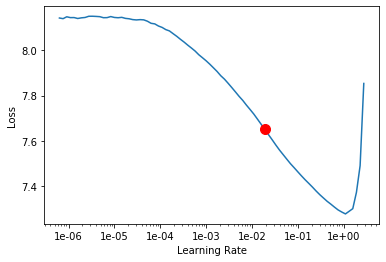

In [17]:
learner.recorder.plot(suggestion=True)

In [18]:
lr = 3e-2
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,6.540890,6.496212,0.041263,0.049683,0.055025,0.048650,0.035704,0.026028,0.110984,0.048522,0.050440,03:58
1,6.385197,6.297712,0.039615,0.081718,0.097371,0.034693,0.094016,0.020446,0.012026,0.063226,0.057057,03:57
2,6.355562,6.421444,0.029260,0.025737,0.045772,0.119636,0.030790,0.021406,0.003943,0.054078,0.041112,03:56
3,5.657079,6.184716,0.231352,0.009346,0.057226,0.068167,0.064644,0.114649,0.094540,0.092756,0.091535,03:56
4,6.161880,6.165552,0.128117,0.092633,0.048225,0.080652,0.048255,0.019635,0.032292,0.088015,0.067498,03:56
5,5.729640,nan,0.194210,0.116560,0.031482,0.036412,0.025910,0.016523,0.049939,0.096576,0.070918,03:57
6,5.315919,6.116616,0.085050,0.089619,0.075204,0.077727,0.070950,0.024732,0.051718,0.081978,0.069912,03:57
7,4.949129,6.078284,0.080878,0.127211,0.057318,0.080872,0.063526,0.030396,0.051153,0.087040,0.072566,03:56
8,4.719989,6.221037,0.017360,0.073513,0.075077,0.108434,0.065329,0.034075,0.039254,0.067781,0.060139,03:56
9,4.627180,6.164599,0.037863,0.083882,0.083269,0.111478,0.065969,0.031037,0.041800,0.078532,0.066764,03:56


### No TD-Laterals

In [14]:
instructor = SequentialInstuctor(range(16))
learner = cs.cs_learner(data, models.resnet18, instructor, loss_func=loss, callback_fns=pose.Pckh, td_laterals=False)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.37E-03
Min loss divided by 10: 1.91E-01


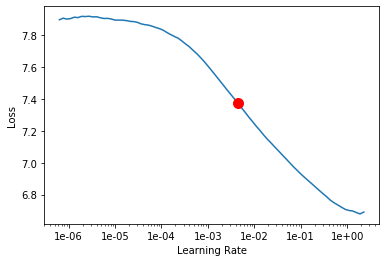

In [9]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [15]:
lr = 1e-2
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,5.083409,5.154305,0.303111,0.223359,0.101292,0.110472,0.132198,0.253712,0.369983,0.187128,0.206663,03:57
1,4.020000,5.579527,0.179168,0.127428,0.118390,0.106452,0.108654,0.204289,0.216906,0.133624,0.147620,03:50
2,3.838617,5.371337,0.204667,0.119415,0.117767,0.124152,0.135060,0.189069,0.244813,0.142239,0.157987,03:49
3,3.693671,5.583122,0.135586,0.081122,0.134518,0.119070,0.045651,0.242984,0.136951,0.117424,0.124506,03:47
4,3.596266,5.530437,0.066402,0.079165,0.194414,0.122432,0.040372,0.172833,0.070232,0.114205,0.105783,03:48
5,3.494495,5.641238,0.102205,0.040385,0.067169,0.123001,0.071969,0.156774,0.201151,0.082846,0.103130,03:47
6,3.387580,5.683234,0.115186,0.046143,0.073705,0.104937,0.052954,0.122550,0.116030,0.084916,0.088181,03:48
7,3.281731,5.655445,0.108387,0.058615,0.073352,0.092701,0.038479,0.113917,0.118092,0.083353,0.084144,03:47
8,3.205997,5.723706,0.084793,0.060656,0.076736,0.084824,0.040059,0.062185,0.090242,0.076662,0.070778,03:57
9,3.178195,5.703852,0.083557,0.047020,0.072820,0.086651,0.041423,0.085170,0.112610,0.072348,0.073596,03:48


## Head To Bottom order

In [5]:
inst = ['B_Head', 'B_Neck', 'R_Shoulder', 'R_Elbow', 'R_Wrist', 'L_Shoulder', 'L_Elbow', 'L_Wrist',
        'B_Spine', 'B_Pelvis', 'R_Knee', 'R_Hip', 'R_Ankle', 'L_Knee', 'L_Hip', 'L_Ankle']
inst = get_indices(inst)
inst

[9, 8, 12, 11, 10, 13, 14, 15, 7, 6, 1, 2, 0, 4, 3, 5]

In [6]:
instructor = SequentialInstuctor(inst)
learner = cs.cs_learner(data, models.resnet18, instructor, loss_func=loss, callback_fns=pose.Pckh)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-02
Min loss divided by 10: 1.58E-01


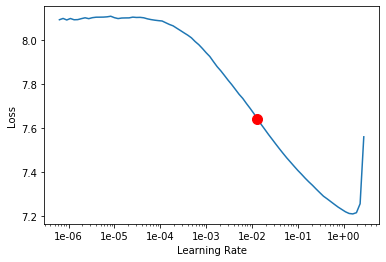

In [7]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

In [8]:
lr = 1.5e-2
learner.fit_one_cycle(10, lr)

epoch,train_loss,valid_loss,Head,Shoulder,Elbow,Wrist,Hip,Knee,Ankle,UBody,Total,time
0,6.552399,6.527926,0.019009,0.014408,0.044033,0.062911,0.095925,0.026533,0.023255,0.034551,0.041606,04:45
1,6.091262,6.491149,0.044148,0.056828,0.053976,0.053143,0.061984,0.031864,0.020463,0.051954,0.047589,04:07
2,6.205669,6.648709,0.022357,0.075170,0.081385,0.035681,0.056155,0.031796,0.010214,0.053677,0.046674,04:04
3,6.017699,6.163223,0.127086,0.045678,0.039525,0.101270,0.043396,0.025989,0.192424,0.078639,0.078804,04:13
4,5.410004,6.342116,0.194158,0.044988,0.044944,0.076349,0.036752,0.052499,0.233349,0.091207,0.093291,04:02
5,4.868224,6.047233,0.118535,0.117959,0.049711,0.081287,0.073021,0.077332,0.247225,0.092542,0.104168,04:10
6,4.498189,6.280391,0.135895,0.061855,0.026256,0.055089,0.091973,0.093770,0.125323,0.070572,0.082496,04:08
7,4.248691,6.079711,0.173604,0.058342,0.035882,0.094848,0.120886,0.091127,0.098218,0.091394,0.096496,04:00
8,4.075354,6.502658,0.096796,0.024933,0.032592,0.065249,0.068174,0.069917,0.104298,0.055133,0.064169,04:01
9,3.973394,6.543628,0.092417,0.016227,0.030741,0.062374,0.087235,0.070432,0.049185,0.050605,0.058442,04:00
